# NLP Automatic Ticket Assignment Project


# Step 1 : Importing Dependencies

In [1]:
# !pip install chart_studio
# !pip install wordcloud
# !pip install ftfy

# Standard Library
import pandas as pd
import numpy as np

from ftfy import *
import nltk

from utils.visualization import *
from utils.datapreprocessing import *

import missingno as msno
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns 

# For Translation
from googletrans import Translator
from langdetect import detect

# Step 2. Importing Data and performing basic EDA

In [2]:
filename= "dataset/input_data.xlsx"
df = pd.read_excel(filename, lines=True)

In [3]:
df.head(5)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [4]:
df.count()

Short description    8492
Description          8499
Caller               8500
Assignment group     8500
dtype: int64

In [5]:
# Convert datatype to string
# df = df.applymap(str)
# df.count()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


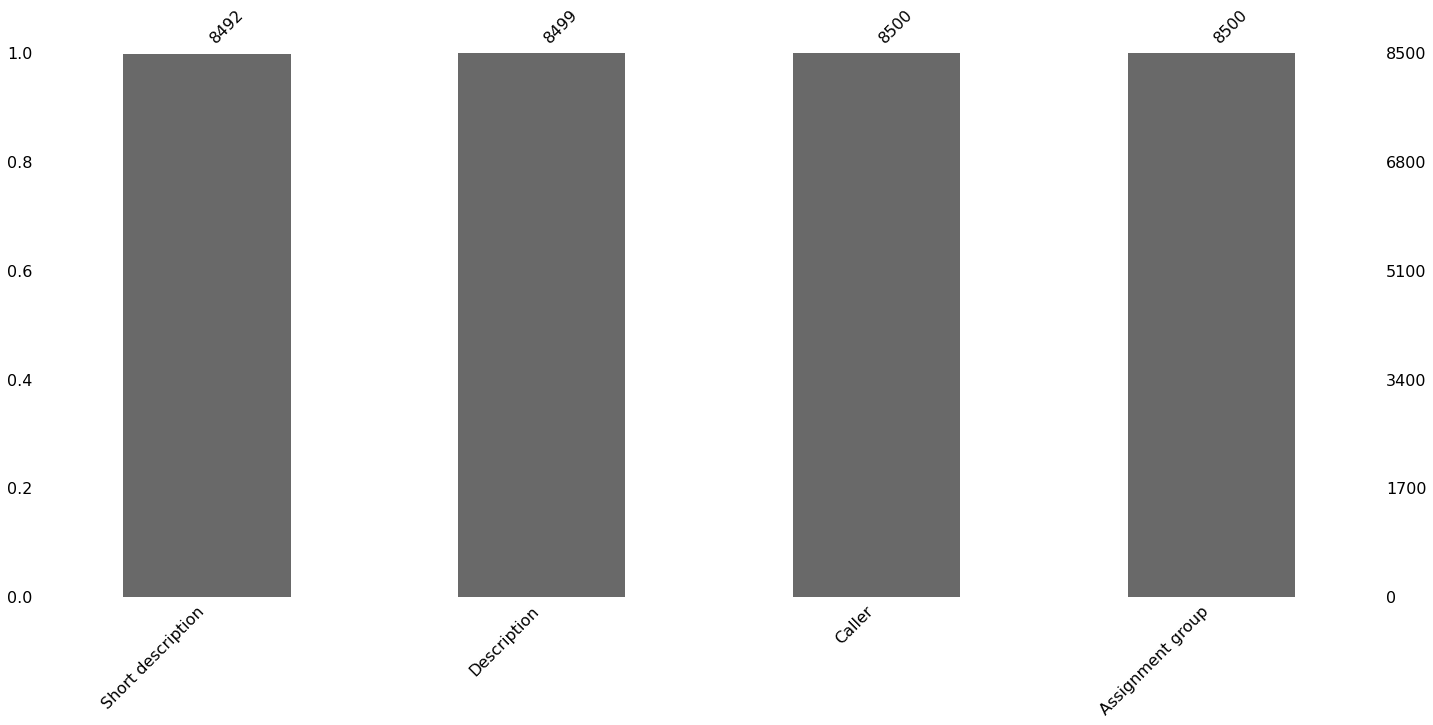

In [7]:
msno.bar(df)

## NOTE : There are 8 NaN Values in 'Short description' Feature, and 1 NaN value in 'Description' Feature.

In [8]:
df['Assignment group'].value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_61       1
GRP_35       1
GRP_64       1
GRP_67       1
GRP_70       1
Name: Assignment group, Length: 74, dtype: int64

## NOTE : There are 74 Dependent/Target classes which are required to be predicted by our Model

# Step 3 : Finding and Treating Missing Values using Rake

## 3(a). Finding NaN Values in 'Short Description' and 'Description'

In [9]:
# For Short Description
df[df['Short description'].isnull()][['Short description', 'Description']]

,Short description,Description
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...
3383,NaN,\r\n-connected to the user system using teamvi...
3906,NaN,-user unable tologin to vpn.\r\n-connected to...
3910,NaN,-user unable tologin to vpn.\r\n-connected to...
3915,NaN,-user unable tologin to vpn.\r\n-connected to...
3921,NaN,-user unable tologin to vpn.\r\n-connected to...
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...
4341,NaN,\r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...


In [10]:
# For Description
df[df['Description'].isnull()][['Short description', 'Description']]

,Short description,Description
4395,i am locked out of skype,NaN


## 3(b). Importing and implementing RAKE(Rapid Automatic Keyword Extraction algorithm) for extracting Key phrases
---------------
* Rake extract Key phrases in a body of text by analyzing the frequency of word appearance and its co-occurance with other words in the text. 

* We will group rows of simillar Key phrases and fill missing NaN values from its simillar rows

In [11]:
r = Rake()

In [12]:
# Imputing NaN values in 'Short description' based upon corresponding 'Description' values from other simillar rows in df
df.at[2604, 'Short description'] = 'NaN'
df.at[3383, 'Short description'] = 'NaN'
df.at[3906, 'Short description'] = 'NaN'
df.at[3910, 'Short description'] = 'NaN'
df.at[3915, 'Short description'] = 'NaN'
df.at[3921, 'Short description'] = 'NaN'
df.at[3924, 'Short description'] = 'NaN'
df.at[4341, 'Short description'] = 'NaN'

# Imputing NaN values in 'Description' based upon corresponding 'Description' values from other simillar rows in df
df.at[4395, 'Description'] = 'NaN'

### Implimenting and Extracting Key Phrases in 'Description' and 'Short description'
-----------

In [13]:
df['Raked Short description'] = df['Short description'].apply(rake_implement)
df['Raked Description'] = df['Description'].apply(rake_implement)

### Key Phrases(od Description) for rows with missing Short description values
------

In [14]:
for i in df[df['Short description'] == 'NaN']['Raked Description']:
    print(i, "\n")

['kindly resolve yhe issue', 'urgent basis', 'com hi', 'working', 'rezuibdt', 'received', 'ohdrnswl', 'link', 'gmail', 'best'] 

['user system using teamviewer', 'user login', 'issue resolved', 'portal', 'help', 'connected'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected'] 

['user system using teamviewer', 'vpn company vpn link', 'company vpn using', 'user unable tologin', 'user login', 'issue resolved', 'vpn', 'help', 'connected'] 

['microsoft internet explorer email', 'happen please help aerp', 'com customer number', 'wvqgbdhm fwchqjor language', 'te

### Corresponding 'Description values' for NaN 'Short description' rows

In [15]:
for ind in [2604, 3383, 3906, 3910, 3915, 3921, 3924, 4341]:
    print("---"*3, "Row Id ", ind, "---"*3)
    print(df.iloc[ind, 1], "\n")

--------- Row Id  2604 ---------


received from: ohdrnswl.rezuibdt@gmail.com

hi,



link is not working. kindly resolve yhe issue on urgent basis.



best  

--------- Row Id  3383 ---------

-connected to the user system using teamviewer.
-help the user login to the portal.
-issue resolved. 

--------- Row Id  3906 ---------
-user unable  tologin to vpn.
-connected to the user system using teamviewer.
-help the user login to the company vpn using the vpn company vpn link.
-issue resolved. 

--------- Row Id  3910 ---------
-user unable  tologin to vpn.
-connected to the user system using teamviewer.
-help the user login to the company vpn using the vpn company vpn link.
-issue resolved. 

--------- Row Id  3915 ---------
-user unable  tologin to vpn.
-connected to the user system using teamviewer.
-help the user login to the company vpn using the vpn company vpn link.
-issue resolved. 

--------- Row Id  3921 ---------
-user unable  tologin to vpn.
-connected to the user system usin

### Corresponding 'Short description values' for NaN 'Description' rows

In [16]:
print("---"*3, "Row Id 4395", "---"*3)
print(df.iloc[4395, 0], "\n")

--------- Row Id 4395 ---------
i am locked out of skype 



## 3(b). Replacing NaN Values in 'Short Description' and 'Description' with simillar values from other rows

In [17]:
# Imputing NaN values in 'Short description' based upon corresponding 'Description' values from other simillar rows in df
df.at[2604, 'Short description'] = 'link not working'
df.at[3383, 'Short description'] = 'login issue'
df.at[3906, 'Short description'] = 'vpn login issue'
df.at[3910, 'Short description'] = 'vpn login issue'
df.at[3915, 'Short description'] = 'vpn login issue'
df.at[3921, 'Short description'] = 'vpn login issue'
df.at[3924, 'Short description'] = 'vpn login issue'
df.at[4341, 'Short description'] = 'login failure erp'

# Imputing NaN values in 'Description' based upon corresponding 'Description' values from other simillar rows in df
df.at[4395, 'Description'] = 'i am locked out of skype'

print("Succesfully replaced all NaN values in NaN Values in 'Short Description' and 'Description' feature.")

Succesfully replaced all NaN values in NaN Values in 'Short Description' and 'Description' feature.


In [18]:
df.count().T

Short description          8500
Description                8500
Caller                     8500
Assignment group           8500
Raked Short description    8500
Raked Description          8500
dtype: int64

## NOTE : We can verify that there are no more missing values in any of the features.

# Step 4 : Data Cleaning : Fixing Garbled Text/ Mojibake/Replacing Contractions and Lemmitization
------------------
### The most interesting kind of brokenness that ftfy will fix is when someone has encoded Unicode with one standard and decoded it with a different one. This often shows up as characters that turn into nonsense sequences (called “mojibake”)

## 5(a). Garbled Text/ Mojibake

In [19]:

# Before cleaning Garbled Text/Mojibakes with ftfy
df['Description'][164]

'\n\nreceived from: abcdri@company.com\n\nwindy shi å°†æ’¤å›žé‚®ä»¶"ticket_no1564867 -- comments added"ã€‚\n\n\næœ¬è®¯æ\x81¯ä»…ä¾›æŒ‡å®šçš„æŽ¥æ”¶äººä½¿ç”¨ï¼Œå…¶ä¸\xadå\x8f¯èƒ½åŒ…å\x90«é€‚ç”¨æ³•å¾‹é¡¹ä¸‹ç‰¹è®¸çš„ã€\x81ä¿\x9då¯†çš„å’Œç¦\x81æ\xad¢æŠ«éœ²çš„å†…å®¹ã€‚é™¤æŒ‡å®šçš„æŽ¥æ”¶äººå¤–ï¼Œä¸¥ç¦\x81å…¶ä»–ä»»ä½•äººä¼\xa0æ’\xadã€\x81åˆ†å\x8f‘æˆ–å¤\x8dåˆ¶æœ¬è®¯æ\x81¯ã€‚å¦‚æžœæ‚¨è¯¯æ”¶åˆ°æœ¬è®¯æ\x81¯ï¼Œè¯·é€šçŸ¥å\x8f‘ä»¶äººå¹¶å°†è®¯æ\x81¯åˆ\xa0é™¤ã€‚\n[\nselect the following link to view the disclaimer in an alternate language. '

In [20]:
### Applying ftfy.fix_text 
df['Short description'] = df['Short description'].apply(fix_text)
df['Description'] = df['Description'].apply(fix_text)

## 5(b). Replacing Contractions and Lemmitization

In [21]:
for short_des in df['Short description']:
    short_des = clean_text(short_des)
print("'Short description' cleaning is complete.")

'Short description' cleaning is complete.


In [22]:
for des in df['Description']:
    des = clean_text(des)
print("'Description' Cleaning is complete.")

'Description' Cleaning is complete.


In [23]:
# Clean dataset cloumn Complete_Description

#cleanDataset(df, 'Short description', getRegexList())
#cleanDataset(df, 'Description', getRegexList())
#cleanDataset(df, 'Complete_Description', getRegexList())

# Performing a Regex_clean is causing many data to be dropped. HTML Characters/ Non standard syntax and vocabulary characters or words Later

### Checking Data after ftfy/Contraction replacement and Lemmitization

In [24]:
# After cleaning Garbled Text/Mojibakes with ftfy.fix_text
df['Description'][164]

'\n\nreceived from: abcdri@company.com\n\nwindy shi 将撤回邮件"ticket_no1564867 -- comments added"。\n\n\n本讯息仅供指定的接收人使用,其中可能包含适用法律项下特许的、保密的和禁止披露的内容。除指定的接收人外,严禁其他任何人传播、分发或复制本讯息。如果您误收到本讯息,请通知发件人并将讯息删除。\n[\nselect the following link to view the disclaimer in an alternate language. '

## NOTE : We can see that apart from English there are many non-english data points. The objective of the next step is to treat the non English language objects in df.(yet to be done)

## NOTE : We can see many non english noise in data, but we will do a second stage text filtering after translation is done, because many of the non english data will be dropped after being mistakened as noise. 

# Step 5 : Translation

In [25]:
# Inputting Path
filename= "dataset/translated_input_data.csv"

# Importing CSV as df
vaishakh_df = pd.read_csv(filename)

#Renaming Columns
vaishakh_df.columns = ['Short description', 'Description', 'Caller', 'Assignment group', 'Iso_Description', 'Language_Description', 'Translated_Description', 'Iso_Short description', 'Language_Short description', 'Translated_Short description']

In [26]:
vaishakh_df.head()

,Short description,Description,Caller,Assignment group,Iso_Description,Language_Description,Translated_Description,Iso_Short description,Language_Short description,Translated_Short description
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,en,English,-verified user details.(employee# & manager na...,en,English,login issue
1,outlook,received from: hmjdrvpb.komuaywn@gmail.com ...,hmjdrvpb komuaywn,GRP_0,en,English,received from: hmjdrvpb.komuaywn@gmail.com ...,en,English,outlook
2,cant log in to vpn,received from: eylqgodm.ybqkwiam@gmail.com ...,eylqgodm ybqkwiam,GRP_0,en,English,received from: eylqgodm.ybqkwiam@gmail.com ...,en,English,cant log in to vpn
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,en,English,unable to access hr_tool page,en,English,unable to access hr_tool page
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,ja,Japanese,skype error,ja,Japanese,skype error


In [32]:
vaishakh_df.head(5)

,Short description,Description,Caller,Assignment group,Iso_Description,Language_Description,Translated_Description,Iso_Short description,Language_Short description,Translated_Short description
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,en,English,-verified user details.(employee# & manager na...,en,English,login issue
1,outlook,received from: hmjdrvpb.komuaywn@gmail.com ...,hmjdrvpb komuaywn,GRP_0,en,English,received from: hmjdrvpb.komuaywn@gmail.com ...,en,English,outlook
2,cant log in to vpn,received from: eylqgodm.ybqkwiam@gmail.com ...,eylqgodm ybqkwiam,GRP_0,en,English,received from: eylqgodm.ybqkwiam@gmail.com ...,en,English,cant log in to vpn
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,en,English,unable to access hr_tool page,en,English,unable to access hr_tool page
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,ja,Japanese,skype error,ja,Japanese,skype error


In [28]:
vaishakh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Short description             8492 non-null   object
 1   Description                   8499 non-null   object
 2   Caller                        8500 non-null   object
 3   Assignment group              8500 non-null   object
 4   Iso_Description               8500 non-null   object
 5   Language_Description          8500 non-null   object
 6   Translated_Description        8499 non-null   object
 7   Iso_Short description         8500 non-null   object
 8   Language_Short description    8500 non-null   object
 9   Translated_Short description  8492 non-null   object
dtypes: object(10)
memory usage: 664.2+ KB


In [29]:
translated_df = pd.concat([df, vaishakh_df.drop(['Short description', 'Description', 'Caller', 'Assignment group'], axis=1)], axis=1)

In [30]:
translated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Short description             8500 non-null   object
 1   Description                   8500 non-null   object
 2   Caller                        8500 non-null   object
 3   Assignment group              8500 non-null   object
 4   Raked Short description       8500 non-null   object
 5   Raked Description             8500 non-null   object
 6   Iso_Description               8500 non-null   object
 7   Language_Description          8500 non-null   object
 8   Translated_Description        8499 non-null   object
 9   Iso_Short description         8500 non-null   object
 10  Language_Short description    8500 non-null   object
 11  Translated_Short description  8492 non-null   object
dtypes: object(12)
memory usage: 797.0+ KB


In [31]:
translated_df.head(5)

,Short description,Description,Caller,Assignment group,Raked Short description,Raked Description,Iso_Description,Language_Description,Translated_Description,Iso_Short description,Language_Short description,Translated_Short description
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,[login issue],"[verified user details, user name, manager nam...",en,English,-verified user details.(employee# & manager na...,en,English,login issue
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,[outlook],"[somebody please advise, com hello team, skype...",en,English,received from: hmjdrvpb.komuaywn@gmail.com ...,en,English,outlook
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,"[cant log, vpn]","[vpn best, com hi, cannot log, ybqkwiam, recei...",en,English,received from: eylqgodm.ybqkwiam@gmail.com ...,en,English,cant log in to vpn
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,"[access hr_tool page, unable]","[access hr_tool page, unable]",en,English,unable to access hr_tool page,en,English,unable to access hr_tool page
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,[skype error],[skype error],ja,Japanese,skype error,ja,Japanese,skype error


## 5(a). Detecting and translating the language in "Short_description" features

In [30]:
#df['Translated Short description'] = df['Short description']

In [58]:
'''
for i in range(0,df.shape[0]):
    try:
        Short_description_language = detect(str(df['Short description'][i]))
        if detect(str(df['Short description'][i])) != 'en':
            df['Translated Short description'][i] = Translator().translate(str(df['Short description'][i]),
                                                                            src= Short_description_language,
                                                                            dest='en').text
        else:
            df['Translated Short description'][i] = str(df['Short description'][i])
    except:
        print("This row throws and error:", i)
        df['Translated Short description'][i] = str(df['Short description'][i])
'''

In [84]:

print("German (Before Translation):", translated_df['Short description'][1622])
print('\nEnglish (After Translation): ', translated_df['Translated_Short description'][1622])

German (Before Translation): nachdem ich outlook geöffnet habe und eine e-mail angeklickt habe kommt ein blauer kreis der sich dreht und ich nichts 

English (After Translation):  after I open outlook and have an e-mail clicked is a blue circle rotates and I nothing


In [87]:
print("German (Before Translation):",translated_df['Short description'][164])
print('\nEnglish (After Translation): '+translated_df['Translated_Short description'][164])

German (Before Translation): 撤回: ticket_no1564867 -- comments added

English (After Translation): 撤回: ticket_no1564867 -- comments added


## 5(b). Detecting and translating the language in "Description" features

In [26]:
#df['Translated Description'] = df['Description']

In [88]:
'''
for i in range(0,df.shape[0]):
    Description_lang = detect(str(df['Description'][i]))
    try:
        if Description_lang != 'en' : #de
            df['Translated Description'][i] = Translator().translate(str(df['Description'][i]),src= Description_lang, dest='en').text
            print("Current Time for Row Id ", i, "with Language ",Description_lang," is: ", current_time)
        else:
            df['Translated Description'][i] = str(df['Description'][i])
    except:
        print("This row throws and error:", i)
        df['Translated Description'][i] = str(df['Description'][i])
'''

'\nfor i in range(0,df.shape[0]):\n    Description_lang = detect(str(df[\'Description\'][i]))\n    try:\n        if Description_lang != \'en\' : #de\n            df[\'Translated Description\'][i] = Translator().translate(str(df[\'Description\'][i]),src= Description_lang, dest=\'en\').text\n            print("Current Time for Row Id ", i, "with Language ",Description_lang," is: ", current_time)\n        else:\n            df[\'Translated Description\'][i] = str(df[\'Description\'][i])\n    except:\n        print("This row throws and error:", i)\n        df[\'Translated Description\'][i] = str(df[\'Description\'][i])\n'

In [89]:

print("German (Before Translation):",translated_df['Description'][1622])
print('\nEnglish (After Translation): '+translated_df['Translated_Description'][1622])

German (Before Translation): mehr machen. bitte dringend um hilfe. meine mobile tel. nr. 

English (After Translation): make more. Please urgently for help. my mobile tel. No.


In [90]:
print("Chinese (Before Translation):",translated_df['Description'][164])
print('\nEnglish (After Translation): '+translated_df['Translated_Description'][164])

Chinese (Before Translation): 

received from: abcdri@company.com

windy shi 将撤回邮件"ticket_no1564867 -- comments added"。


本讯息仅供指定的接收人使用,其中可能包含适用法律项下特许的、保密的和禁止披露的内容。除指定的接收人外,严禁其他任何人传播、分发或复制本讯息。如果您误收到本讯息,请通知发件人并将讯息删除。
[
select the following link to view the disclaimer in an alternate language. 

English (After Translation): received from: abcdri@company.com windy shi will recall message "ticket_no1564867 - comments added". This message is for the designated recipient to use, which may contain privileged under applicable law, confidentiality and non-disclosure of content. In addition to the designated recipient, any other person is strictly prohibited dissemination, distribution or copying of this message. If you receive this message by mistake, please notify the sender and delete the message. [Select the following link to view the disclaimer in an alternate language.


## 5(c). Findind and fixing missing values in translated data i.e. translated_df
---------------
-> 8 Values are missing in Tranlated_Short description <br>
-> 1 Value is missing in translated_Description <br>
-> All the values missing are in english language <br>
-> We will simply copy the corresponding original values

In [36]:
# For Translated Short Description we can see the respective row values are in english
translated_df[translated_df['Translated_Short description'].isnull()][['Short description', 'Description','Translated_Description']]

,Short description,Description,Translated_Description
2604,link not working,\n\nreceived from: ohdrnswl.rezuibdt@gmail.com...,received from: ohdrnswl.rezuibdt@gmail.com ...
3383,login issue,\n-connected to the user system using teamview...,-connected to the user system using teamviewe...
3906,vpn login issue,-user unable tologin to vpn.\n-connected to t...,-user unable tologin to vpn. -connected to th...
3910,vpn login issue,-user unable tologin to vpn.\n-connected to t...,-user unable tologin to vpn. -connected to th...
3915,vpn login issue,-user unable tologin to vpn.\n-connected to t...,-user unable tologin to vpn. -connected to th...
3921,vpn login issue,-user unable tologin to vpn.\n-connected to t...,-user unable tologin to vpn. -connected to th...
3924,vpn login issue,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,name:wvqgbdhm fwchqjor language: browser:micro...
4341,login failure erp,\n\nreceived from: eqmuniov.ehxkcbgj@gmail.com...,received from: eqmuniov.ehxkcbgj@gmail.com ...


In [34]:
# For 'Translated_Description' we can see the respective row values are in english
translated_df[translated_df['Translated_Description'].isnull()][['Short description', 'Translated_Short description', 'Description']]

,Short description,Translated_Short description,Description
4395,i am locked out of skype,i am locked out of skype,i am locked out of skype


In [37]:
# Copying values from 'Short description' which are already correctly imputated
translated_df["Translated_Short description"] = translated_df["Translated_Short description"].fillna(translated_df["Short description"])
print("Succesfully filled all NaN values in 'Translated_Short description'")

Succesfully filled all NaN values in 'Translated_Short description'


In [39]:
# Copying values from 'Description' which are already correctly imputated
translated_df["Translated_Description"] = translated_df["Translated_Description"].fillna(translated_df["Description"])
print("Succesfully filled all NaN values in 'Translated_Description'")

Succesfully filled all NaN values in 'Translated_Description'


In [43]:
# Finding missing values in translated data
translated_df.isnull().sum()

Short description               0
Description                     0
Caller                          0
Assignment group                0
Raked Short description         0
Raked Description               0
Iso_Description                 0
Language_Description            0
Translated_Description          0
Iso_Short description           0
Language_Short description      0
Translated_Short description    0
dtype: int64

In [ ]:
translated_df = translated_df.applymap(str)

# Step 6: Feature Engineering : Text Summarizing for large 'Description'/'Translated_Description' Values  
----------

### Finding rows where length of Translated_Description is more than 200

In [53]:

translated_df.loc[ translated_df['Translated_Description'].apply(lambda x : len(x) > 200) ].shape

(2069, 12)

### Finding rows where length of Translated_Description is more than 500

In [54]:
translated_df.loc[ translated_df['Translated_Description'].apply(lambda x : len(x) > 500) ].shape

(578, 12)

### Finding rows where length of Translated_Description is more than 800

In [55]:
translated_df.loc[ translated_df['Translated_Description'].apply(lambda x : len(x) > 800) ].shape

(361, 12)

In [57]:
str_me = '''received from: abcdri@company.com windy shi will recall message "ticket_no1564867 - comments added". This message is for the designated recipient to use, which may contain privileged under applicable law, confidentiality and non-disclosure of content. In addition to the designated recipient, any other person is strictly prohibited dissemination, distribution or copying of this message. If you receive this message by mistake, please notify the sender and delete the message. [Select the following link to view the disclaimer in an alternate language.'''

str_summr = create_summarized_feature(str_me)
print(str_summr)

NameError: name 'create_summarized_feature' is not defined

# Step 7: Feature Engineering : Creating a 'Complete_Description' by concatinating 'Short description' and 'Description' Values  
----------

In [ ]:
# Concatenate Short description and Description
df['Complete_Description'] = df['Description'] + " " + df['Short description']
df.head(10)

## Finally coverting the df values to str type

In [ ]:
# We will use applymap() as it works element-wise on a DataFrame, whereas apply() works on a row / column basis of a DataFrame
df = df.applymap(str)

# Step 6. Translation

In [81]:
df.head()

,Short description,Description,Caller,Assignment group,Complete_Description,Short description_en,Description_en
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,-verified user details.(employee# & manager na...,,
1,outlook,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,hmjdrvpb komuaywn,GRP_0,\n\nreceived from: hmjdrvpb.komuaywn@gmail.com...,,
2,cant log in to vpn,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,eylqgodm ybqkwiam,GRP_0,\n\nreceived from: eylqgodm.ybqkwiam@gmail.com...,,
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable to access hr_tool page unable to access...,,
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error skype error,,


# Step 7. Removing Stop Words
---------
### Except 'the' as a stop word. We will white list it.

In [121]:
import re
import nltk
nltk.download('stopwords')

stop = set(stopwords.words('english'))
#not is in the stopword list. W/O adding whitelist, the summary would change from "do not recommend" to "recommend". This solution was borrowed from bertcarremans https://github.com/bertcarremans/TwitterUSAirlineSentiment

whitelist = ["the", "n't", "not", "no"]

df['Description'] = df['Description'].apply(lambda x: ' '.join([word for word in x.split() if word in whitelist or word not in (stop)]))

df['Short description'] = df['Short description'].apply(lambda x: ' '.join([word for word in x.split() if word in whitelist or word not in (stop)]))

df['Complete_Description'] = df['Complete_Description'].apply(lambda x: ' '.join([word for word in x.split() if word in whitelist or word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Soumendra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'stopwords' is not defined

# Step 6 : Word Cloud Visualization

#### Word Cloud of "Short descrition" Column

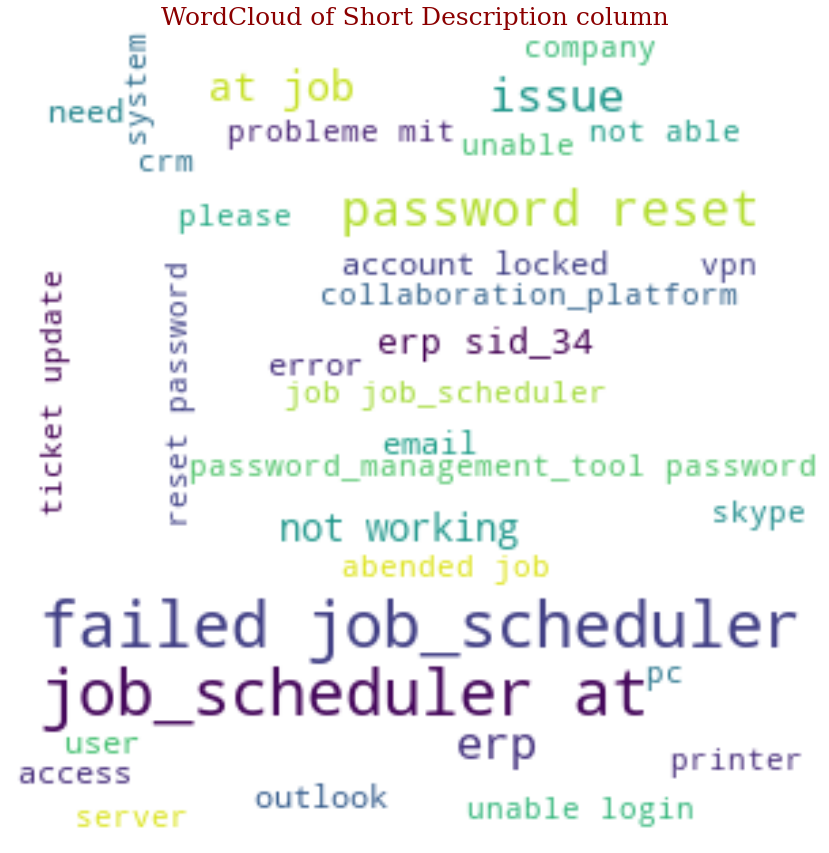

In [121]:
word_cloud_visulization(df['Short description'], "Short Description", stopword=True)

#### Word Cloud of "Description" Column

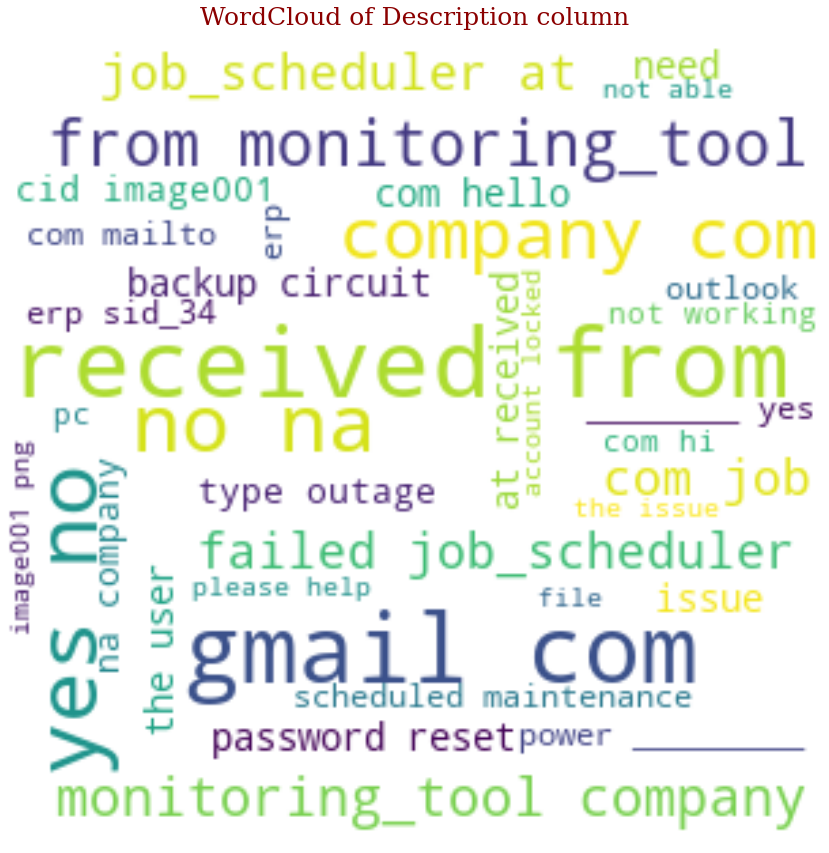

In [122]:
word_cloud_visulization(df['Description'], "Description", stopword=True)

#### Word Cloud of "Complete Description" Column

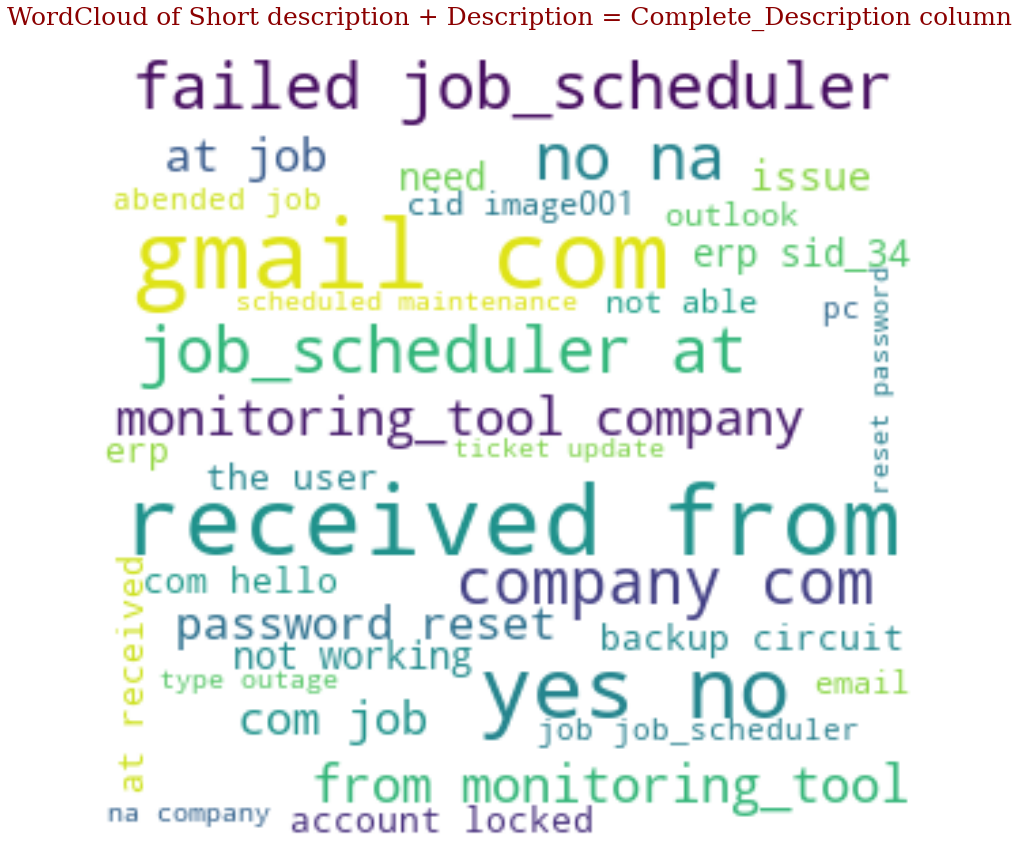

In [123]:
# Concatenate Short description + Description = Complete_Description
word_cloud_visulization(df['Complete_Description'], "Short description + Description = Complete_Description", stopword=True)

#### Word Cloud of "Caller" Column

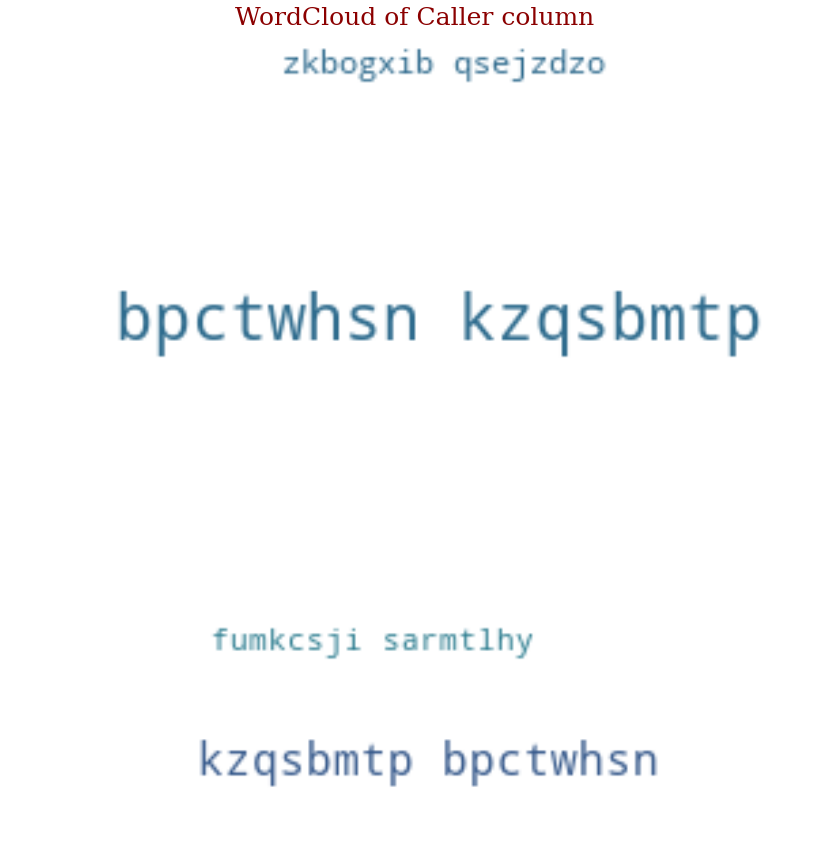

In [124]:
word_cloud_visulization(df['Caller'], "Caller", stopword=True)

# Step 7 : Feature Engineering : Adding Length and word count for 'Complete_Description' as two now Features 
-----------------
## We will add  a Length and a word count for 'Complete_Description' attribute as two now features in df for the purpose of EDA. 

In [125]:
# Adding Word count and Description Length
df['review_len'] = df['Complete_Description'].astype(str).apply(len)
df['word_count'] = df['Complete_Description'].apply(lambda x: len(str(x).split()))

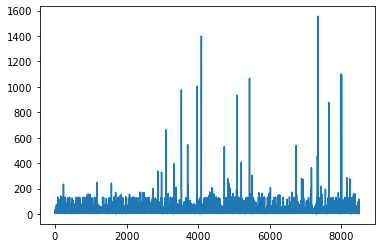

In [126]:
# Word Count Distribution for Description
df['word_count'].plot(
    x='word_count',
    y='count')

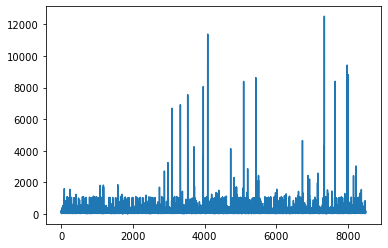

In [127]:
# Description Length Distribution
df['review_len'].plot(
    x='review length',
    y='count')

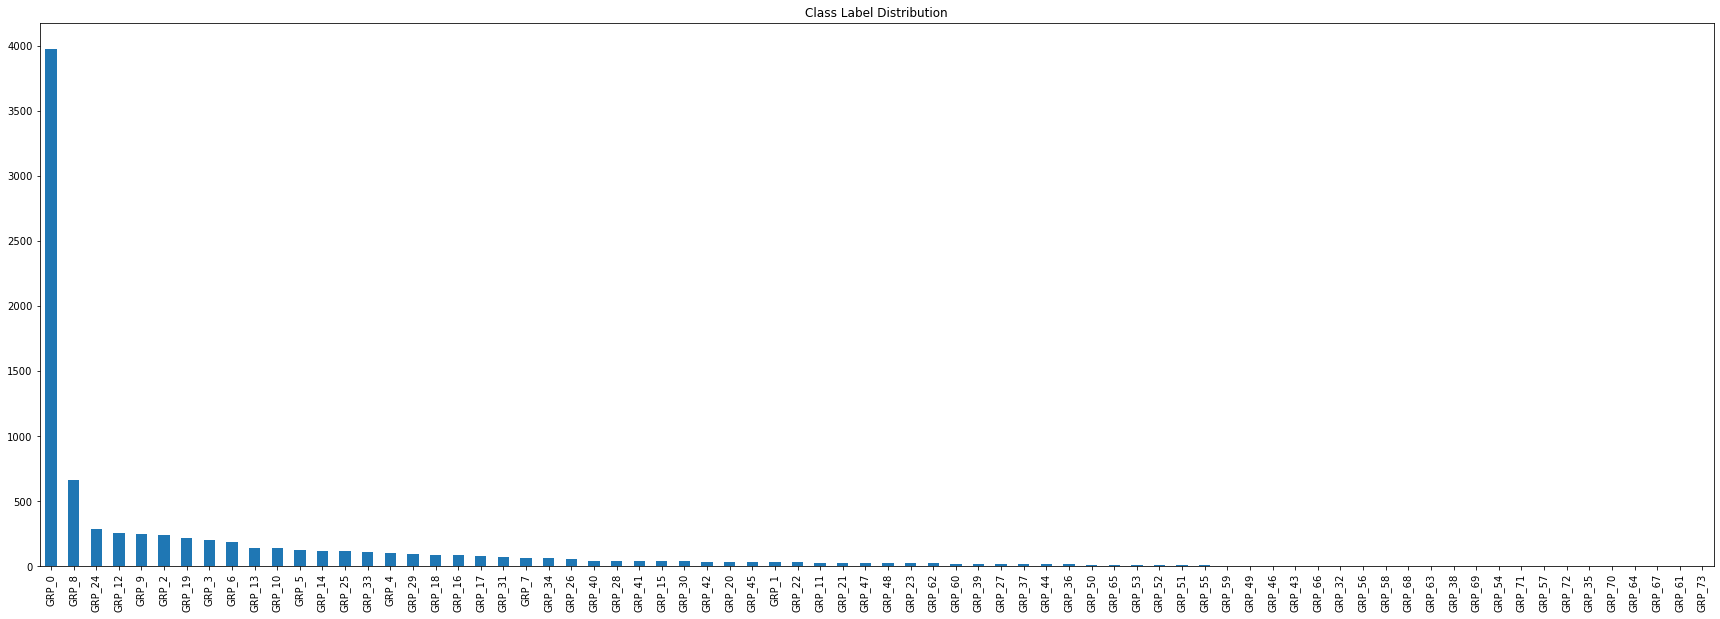

In [128]:
# Assignment group distribution
df['Assignment group'].value_counts().plot(kind='bar', figsize=(30,10), title='Class Label Distribution')

In [129]:
df.head()

,Short description,Description,Caller,Assignment group,Complete_Description,review_len,word_count
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,-verified user details.(employee# & manager na...,185,27
1,outlook,received from: hmjdrvpb.komuaywn@gmail.com hel...,hmjdrvpb komuaywn,GRP_0,received from: hmjdrvpb.komuaywn@gmail.com hel...,164,19
2,cant log vpn,received from: eylqgodm.ybqkwiam@gmail.com hi ...,eylqgodm ybqkwiam,GRP_0,received from: eylqgodm.ybqkwiam@gmail.com hi ...,78,11
3,unable access hr_tool page,unable access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable access hr_tool page unable access hr_to...,53,8
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error skype error,23,4


In [153]:
# The distribution of top unigrams before removing stop words for Complete_Description

from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

print("---"*5, "Before removing Stop Words", "---"*5)
print(
'''
to 8756
the 7057
in 5181
com 3804
from 3590
is 3558
on 2967
not 2947
company 2773
and 2769
for 2650
at 2504
received 2387
no 2379
2016 2270
00 2258
gmail 2205
please 2180
erp 2056
password 2055
''')
print("---"*5, "After removing Stop Words", "---"*5)

for word, freq in common_words:
    print(word, freq)
# df1 = pd.DataFrame(common_words, columns = ['Description' , 'count'])
# df1.groupby('Description').sum()['count'].sort_values(ascending=False).iplot(
#     kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review before removing stop words')


--------------- Before removing Stop Words ---------------

to 8756
the 7057
in 5181
com 3804
from 3590
is 3558
on 2967
not 2947
company 2773
and 2769
for 2650
at 2504
received 2387
no 2379
2016 2270
00 2258
gmail 2205
please 2180
erp 2056
password 2055

--------------- After removing Stop Words ---------------
com 3804
company 2773
received 2387
2016 2270
00 2258
gmail 2205
erp 2056
password 2055
job 1984
job_scheduler 1928
yes 1792
failed 1735
na 1639
10 1599
reset 1530
unable 1498
user 1469
access 1425
issue 1316
account 1211


In [131]:
# The distribution of top unigrams before and after removing stop words for Complete_Description

def get_top_n_words(corpus, range=(1,1), n=None):
    vec = CountVectorizer(ngram_range=range, stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

print("---"*5, "Before removing Stop Words", "---"*5)
print(
'''
com 3804
company 2773
received 2387
2016 2270
00 2258
gmail 2205
erp 2056
password 2055
job 1984
job_scheduler 1928
yes 1792
failed 1735
na 1639
10 1599
reset 1530
unable 1498
user 1469
access 1425
issue 1316
account 1211
''')

print("---"*5, "After removing Stop Words", "---"*5)

common_words = get_top_n_words(df['Complete_Description'], (1,1),20)
for word, freq in common_words:
    print(word, freq)
# df1 = pd.DataFrame(common_words, columns = ['Description' , 'count'])
# df1.groupby('Description').sum()['count'].sort_values(ascending=False).iplot(
#     kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review before removing stop words')


--------------- Before removing Stop Words ---------------

com 3804
company 2773
received 2387
2016 2270
00 2258
gmail 2205
erp 2056
password 2055
job 1984
job_scheduler 1928
yes 1792
failed 1735
na 1639
10 1599
reset 1530
unable 1498
user 1469
access 1425
issue 1316
account 1211

--------------- After removing Stop Words ---------------
com 3804
company 2773
received 2387
2016 2270
00 2258
gmail 2205
erp 2056
password 2055
job 1984
job_scheduler 1928
yes 1792
failed 1735
na 1639
10 1599
reset 1530
unable 1498
user 1469
access 1425
issue 1316
account 1211


In [154]:
# 
The distribution of top bigrams after removing stop words for Complete_Description

common_words = get_top_n_words(df['Complete_Description'], (2,2),20)
for word, freq in common_words:
    print(word, freq)

SyntaxError: invalid syntax (<ipython-input-154-45e332f74b13>, line 2)

In [ ]:
# 
The distribution of top trigrams after removing stop words for Complete_Description

common_words = get_top_n_words(df['Complete_Description'], (3,3) ,20)
for word, freq in common_words:
    print(word, freq)


# 
Stopwords Removal & Lemmetization

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.

Text preprocessing includes both Stemming as well as Lemmatization. Many times people find these two terms confusing. Some treat these two as same. Actually, lemmatization is preferred over Stemming because lemmatization does morphological analysis of the words.

In [132]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords,wordnet
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer

In [133]:
# # Download Wordnet through NLTK in python console:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Soumendra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Soumendra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Soumendra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Soumendra\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

processed_all_documents = []
for row in df['Complete_Description']:
    word_tokens = word_tokenize(row)
#     print(word_tokens)

    filtered_sentence = [] 

    # Removing Stopwords
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
    
    # Lemmetization
    lemma_word = []
    wordnet_lemmatizer = WordNetLemmatizer()
    for w in filtered_sentence:
        word = wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w))
        lemma_word.append(word)
    words = ' '.join(lemma_word)
    processed_all_documents.append(words)

In [140]:
df['Clean_Description'] = df["Complete_Description"]

df.head()

In [141]:
# Adding Word count and Description Length
df['clean_review_len'] = df['Clean_Description'].astype(str).apply(len)
df['clean_word_count'] = df['Clean_Description'].apply(lambda x: len(str(x).split()))

In [142]:
df.head()

,Short description,Description,Caller,Assignment group,Complete_Description,review_len,word_count,Assignment group LabelEncode,Clean_Description,clean_review_len,clean_word_count
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,-verified user details.(employee# & manager na...,185,27,0,-verified user details.(employee# & manager na...,185,27
1,outlook,received from: hmjdrvpb.komuaywn@gmail.com hel...,hmjdrvpb komuaywn,GRP_0,received from: hmjdrvpb.komuaywn@gmail.com hel...,164,19,0,received from: hmjdrvpb.komuaywn@gmail.com hel...,164,19
2,cant log vpn,received from: eylqgodm.ybqkwiam@gmail.com hi ...,eylqgodm ybqkwiam,GRP_0,received from: eylqgodm.ybqkwiam@gmail.com hi ...,78,11,0,received from: eylqgodm.ybqkwiam@gmail.com hi ...,78,11
3,unable access hr_tool page,unable access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable access hr_tool page unable access hr_to...,53,8,0,unable access hr_tool page unable access hr_to...,53,8
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error skype error,23,4,0,skype error skype error,23,4


word_cloud_visulization(df['Clean_Description'], "Clean_Description", stopword=True)

# Target Feature Label Encoding
---------------
### Label Encoding refers to converting the labels into numeric form so as to convert it into the machine-readable form. Machine learning algorithms can then decide in a better way on how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.

Label Encoding Assignment group	

In [143]:
df['Assignment group'].unique() 

array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38',
       'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50',
       'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56',
       'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',
       'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67',
       'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73'],
      dtype=object)

In [144]:
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
df['Assignment group LabelEncode']= label_encoder.fit_transform(df['Assignment group']) 
  
df['Assignment group LabelEncode'].unique() 

array([ 0,  1, 23, 34, 45, 56, 67, 72, 73,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 27, 28,
       29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 26, 59, 60, 61, 62, 63, 64,
       65, 66, 68, 69, 70, 71])

In [145]:
df.head(10)

,Short description,Description,Caller,Assignment group,Complete_Description,review_len,word_count,Assignment group LabelEncode,Clean_Description,clean_review_len,clean_word_count
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,-verified user details.(employee# & manager na...,185,27,0,-verified user details.(employee# & manager na...,185,27
1,outlook,received from: hmjdrvpb.komuaywn@gmail.com hel...,hmjdrvpb komuaywn,GRP_0,received from: hmjdrvpb.komuaywn@gmail.com hel...,164,19,0,received from: hmjdrvpb.komuaywn@gmail.com hel...,164,19
2,cant log vpn,received from: eylqgodm.ybqkwiam@gmail.com hi ...,eylqgodm ybqkwiam,GRP_0,received from: eylqgodm.ybqkwiam@gmail.com hi ...,78,11,0,received from: eylqgodm.ybqkwiam@gmail.com hi ...,78,11
3,unable access hr_tool page,unable access hr_tool page,xbkucsvz gcpydteq,GRP_0,unable access hr_tool page unable access hr_to...,53,8,0,unable access hr_tool page unable access hr_to...,53,8
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,skype error skype error,23,4,0,skype error skype error,23,4
5,unable log engineering tool skype,unable log engineering tool skype,eflahbxn ltdgrvkz,GRP_0,unable log engineering tool skype unable log e...,67,10,0,unable log engineering tool skype unable log e...,67,10
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1,event: critical:HostName_221.company.com the v...,241,15,1,event: critical:HostName_221.company.com the v...,241,15
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0,ticket_no1550391- employment status - new non-...,149,18,0,ticket_no1550391- employment status - new non-...,149,18
8,unable disable add ins outlook,unable disable add ins outlook,mdbegvct dbvichlg,GRP_0,unable disable add ins outlook unable disable ...,61,10,0,unable disable add ins outlook unable disable ...,61,10
9,ticket update inplant_874773,ticket update inplant_874773,fumkcsji sarmtlhy,GRP_0,ticket update inplant_874773 ticket update inp...,57,6,0,ticket update inplant_874773 ticket update inp...,57,6


### Need of feature extraction techniques
Machine Learning algorithms learn from a pre-defined set of features from the training data to produce output for the test data. But the main problem in working with language processing is that machine learning algorithms cannot work on the raw text directly. So, we need some feature extraction techniques to convert text into a matrix(or vector) of features.
Some of the most popular methods of feature extraction are :

Bag-of-Words

TF-IDF

# Calculating Term Frequency-Inverse Document Frequency (TF-IDF)
--------------
### “Term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.”

In [146]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, confusion_matrix, classification_report


tfidf = TfidfVectorizer()
x_tfidf = tfidf.fit_transform(df['Clean_Description']).toarray()


In [147]:
x_tfidf.shape

(8500, 23077)

In [148]:
x_tfidf[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [149]:
y = df['Assignment group LabelEncode']

In [150]:
y.shape

(8500,)

# Train Test Split

In [151]:
train_x, test_x, train_y, test_y = train_test_split(x_tfidf, y, test_size=0.3)

# Applying ML Classifier

 ## (a).Support Vector Machine

In [152]:
from sklearn.svm import SVC
clf = SVC(kernel='linear').fit(train_x, train_y)
y_pred = clf.predict(test_x)
acc_score = accuracy_score(test_y, y_pred)
print("SVM-Linear Score: ", acc_score)
f_sc = f1_score(test_y, y_pred, average='weighted', labels=np.unique(y_pred))
print("SVM F1 Score: ", f_sc)

SVM-Linear Score:  0.6796078431372549
SVM F1 Score:  0.6696306959893276


#### Naive Bayes

In [58]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)
acc_score = accuracy_score(test_y, y_pred)
print("Naive Bayes Score: ", acc_score)
f_sc = f1_score(test_y, y_pred, average='weighted', labels=np.unique(y_pred))
print("Naive Bayes F1 Score: ", f_sc)

Naive Bayes Score:  0.5317647058823529
Naive Bayes F1 Score:  0.6080369609566022


In [59]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors= 3)
clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)
acc_score = accuracy_score(test_y, y_pred)
print("KNN Classifiers Score: ", acc_score)
f_sc = f1_score(test_y, y_pred, average='weighted', labels=np.unique(y_pred))
print("KNN Classifiers F1 Score: ", f_sc)


KNN Classifiers Score:  0.6396078431372549
KNN Classifiers F1 Score:  0.5979118578172774
